# AI Models for Predicting Influenza-Like Illness in Bahia

### Autor:
[Fernando Schettini](https://linktr.ee/fernandoschett), [Augusto Barreto](https://github.com/augustobarreto).

## Introduction and Context

- Data obtained from opendatasus, August 25, 2024.*
- Surveillance of Influenza-Like Illness (ILI) for mild and moderate cases suspected of COVID-19.
- Identifying circulating respiratory viruses like SARS-CoV-2 and enabling the monitoring of healthcare demand.

*Available at: https://opendatasus.saude.gov.br/dataset/notificacoes-de-sindrome-gripal-leve-2024

## Instalando Pré-Requisitos

Use GPU (Just install it if youre in google colab):

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

In [ ]:
import os
if 'COLAB_GPU' in os.environ:
    print("GPU is enabled")
else:
    print("If in Colab: Change runtime type > Hardware accelerator > GPU.")

GPU is enabled


## Raw Data Visualization

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import cuml

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# Leitura dos Dados
df = pd.read_csv("/content/sample_data/data.csv", sep=";", on_bad_lines='skip')

<ipython-input-7-797447efaf70>:2: DtypeWarning: Columns (12,26,31,33,34,37,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/sample_data/data.csv", sep=";", on_bad_lines='skip')


In [ ]:
df

,sintomas,profissionalSaude,racaCor,outrosSintomas,outrasCondicoes,profissionalSeguranca,cbo,condicoes,sexo,estado,...,codigoResultadoTeste3,codigoEstadoTeste4,codigoTipoTeste4,codigoFabricanteTeste4,codigoResultadoTeste4,dataColetaTeste1,dataColetaTeste2,dataColetaTeste3,dataColetaTeste4,idade
0,Dor de Garganta,Não,Parda,NaN,NaN,Não,NaN,NaN,Feminino,Bahia,...,NaN,NaN,NaN,NaN,NaN,2022-07-01,NaN,NaN,NaN,52.0
1,"Tosse, Dor de Cabeça",Não,Preta,NaN,NaN,Não,NaN,NaN,Feminino,Bahia,...,NaN,NaN,NaN,NaN,NaN,2022-02-15,NaN,NaN,NaN,36.0
2,"Dor de Cabeça, Tosse, Outros",Não,Parda,dor no corpo,NaN,Não,NaN,NaN,Feminino,Bahia,...,NaN,NaN,NaN,NaN,NaN,2022-12-05,NaN,NaN,NaN,NaN
3,"Coriza, Dor de Cabeça, Tosse, Febre, Dor de Ga...",Não,Parda,"DIARREIA, FADIGA E MIALGIA",NaN,Não,NaN,NaN,Feminino,Bahia,...,NaN,NaN,NaN,NaN,NaN,2024-01-19,2022-01-27,NaN,NaN,NaN
4,"Dor de Cabeça, Tosse, Outros",Não,Ignorado,DOR NO CORPO,NaN,Não,NaN,NaN,Feminino,Bahia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150439,"Tosse, Dor de Garganta, Coriza",Não,Amarela,NaN,NaN,Não,NaN,Diabetes,Feminino,Bahia,...,NaN,NaN,NaN,NaN,NaN,2023-11-17,NaN,NaN,NaN,NaN
150440,"Coriza, Febre, Outros",Não,Parda,DOR ABDOMINAL,NaN,Não,NaN,NaN,Masculino,Bahia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
150441,Assintomático,Não,Ignorado,NaN,NaN,Não,NaN,NaN,Feminino,Bahia,...,NaN,NaN,NaN,NaN,NaN,2023-09-12,NaN,NaN,NaN,3.0
150442,"Coriza, Dispneia, Tosse",Não,Parda,NaN,NaN,Não,NaN,Doenças respiratórias crônicas descompensadas,Masculino,Bahia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


In [ ]:
unique_classes = df['classificacaoFinal'].unique()
print("Classes possíveis para predição:", unique_classes)

Classes possíveis para predição: ['Descartado' 'Confirmado Laboratorial' 'Síndrome Gripal Não Especificada'
 nan 'Confirmado por Critério Clínico' 'Confirmado Clínico-Epidemiológico'
 'Confirmado Clínico-Imagem']


In [ ]:
column_names = df.columns
column_names_list = list(column_names)
column_names

Index(['sintomas', 'profissionalSaude', 'racaCor', 'outrosSintomas',
       'outrasCondicoes', 'profissionalSeguranca', 'cbo', 'condicoes', 'sexo',
       'estado', 'estadoIBGE', 'municipio', 'municipioIBGE', 'origem',
       'estadoNotificacao', 'municipioNotificacao', 'municipioNotificacaoIBGE',
       'evolucaoCaso', 'classificacaoFinal', 'codigoEstrategiaCovid',
       'codigoBuscaAtivaAssintomatico', 'outroBuscaAtivaAssintomatico',
       'codigoTriagemPopulacaoEspecifica', 'outroTriagemPopulacaoEspecifica',
       'codigoLocalRealizacaoTestagem', 'outroLocalRealizacaoTestagem',
       'codigoRecebeuVacina', 'codigoLaboratorioPrimeiraDose',
       'codigoLaboratorioSegundaDose', 'lotePrimeiraDose', 'loteSegundaDose',
       'codigoContemComunidadeTradicional', 'source_id', 'excluido',
       'validado', 'codigoDosesVacina', 'estadoNotificacaoIBGE',
       'totalTestesRealizados', 'dataNotificacao', 'dataInicioSintomas',
       'dataEncerramento', 'dataPrimeiraDose', 'dataSegundaDo

## Pré-Processamento

In [ ]:
# Separando Sintomas por coluna.
sintomas_expanded = df['sintomas'].str.get_dummies(sep=', ')

In [ ]:
sintomas_expanded

,Assintomático,Coriza,Dispineia,Dispneia,"Dispneia,Febre,Tosse,",Distúrbios Gustativos,Distúrbios Olfativos,"Dor De Garganta,",Dor de Cabeça,Dor de Garganta,Febre,Outros,Tosse,"Tosse,"
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0,0,1,1,0
3,0,1,0,0,0,0,0,0,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150439,0,1,0,0,0,0,0,0,0,1,0,0,1,0
150440,0,1,0,0,0,0,0,0,0,0,1,1,0,0
150441,1,0,0,0,0,0,0,0,0,0,0,0,0,0
150442,0,1,0,1,0,0,0,0,0,0,0,0,1,0


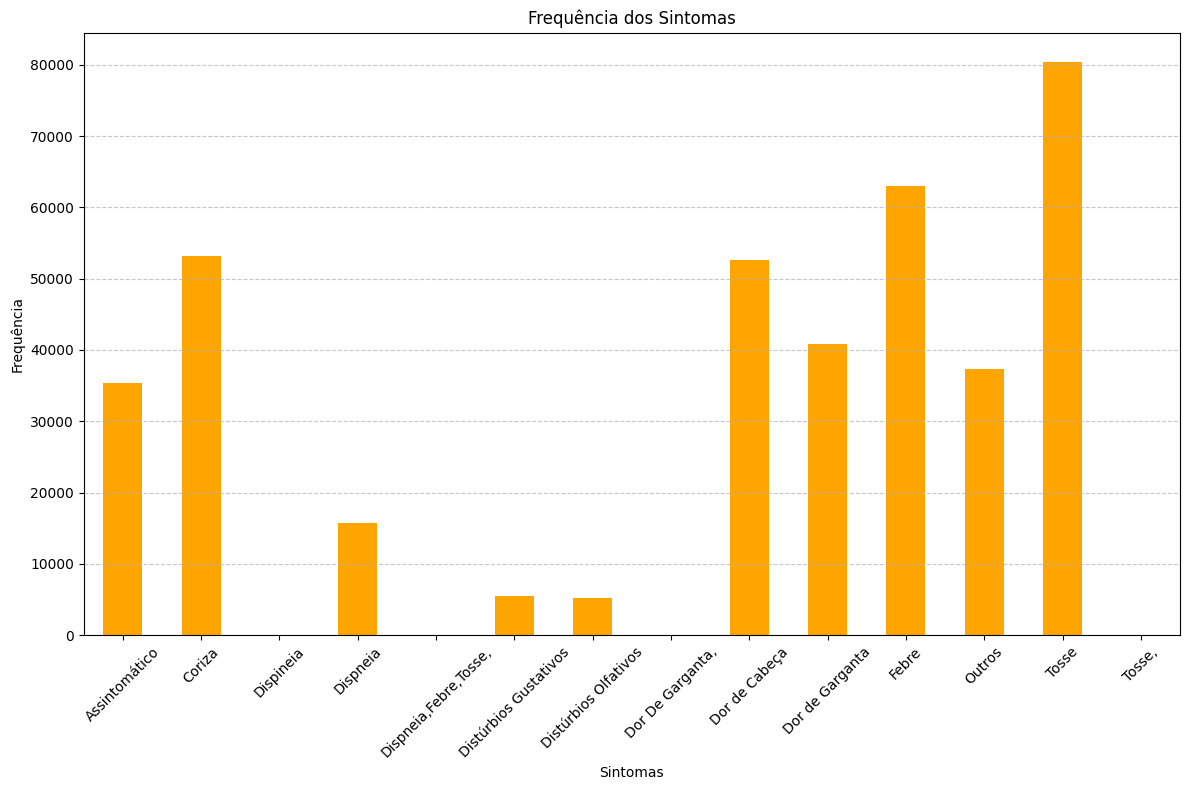

In [ ]:
sintomas_frequencia = sintomas_expanded.sum()

plt.figure(figsize=(12, 8))
sintomas_frequencia.plot(kind='bar', color='orange')
plt.title('Frequência dos Sintomas')
plt.xlabel('Sintomas')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

In [ ]:
one_hot_encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' evita a multicolinearidade

# Aplicar o one hot encoding nas colunas categóricas
encoded_features = one_hot_encoder.fit_transform(df[['racaCor']])

# Converter para DataFrame e adicionar nomes às colunas
encoded_df = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(['racaCor']))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
encoded_df

,racaCor_Branca,racaCor_Ignorado,racaCor_Indigena,racaCor_Parda,racaCor_Preta,racaCor_nan
0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
150439,0.0,0.0,0.0,0.0,0.0,0.0
150440,0.0,0.0,0.0,1.0,0.0,0.0
150441,0.0,1.0,0.0,0.0,0.0,0.0
150442,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
selected_columns = ['idade', 'totalTestesRealizados', 'classificacaoFinal']

In [ ]:
df_p = pd.concat([df[selected_columns], encoded_df, sintomas_expanded], axis=1)

In [ ]:
df_p_clean = df_p.dropna(subset=['classificacaoFinal'])

In [ ]:
df_p_clean['classificacaoFinal_binary'] = df_p_clean['classificacaoFinal'].apply(
    lambda x: 0 if x == 'Descartado' else 1
)

<ipython-input-14-f1866d6dccf0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p_clean['classificacaoFinal_binary'] = df_p_clean['classificacaoFinal'].apply(


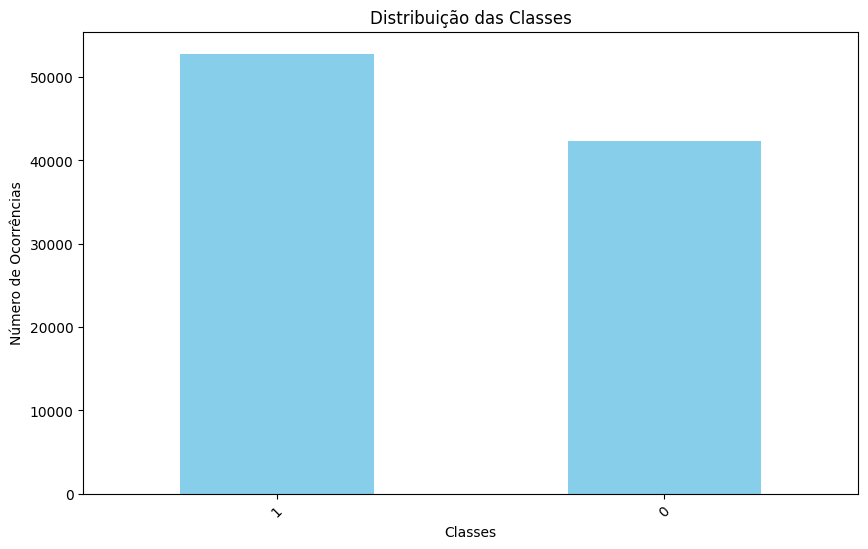

In [ ]:
class_counts = df_p_clean['classificacaoFinal_binary'].value_counts()
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribuição das Classes')
plt.xlabel('Classes')
plt.ylabel('Número de Ocorrências')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_p_clean

,idade,totalTestesRealizados,classificacaoFinal,racaCor_Branca,racaCor_Ignorado,racaCor_Indigena,racaCor_Parda,racaCor_Preta,racaCor_nan,Assintomático,...,Distúrbios Gustativos,Distúrbios Olfativos,"Dor De Garganta,",Dor de Cabeça,Dor de Garganta,Febre,Outros,Tosse,"Tosse,",classificacaoFinal_binary
0,52.0,1,Descartado,0.0,0.0,0.0,1.0,0.0,0.0,0,...,0,0,0,0,1,0,0,0,0,0
1,36.0,1,Confirmado Laboratorial,0.0,0.0,0.0,0.0,1.0,0.0,0,...,0,0,0,1,0,0,0,1,0,1
2,NaN,1,Confirmado Laboratorial,0.0,0.0,0.0,1.0,0.0,0.0,0,...,0,0,0,1,0,0,1,1,0,1
3,NaN,2,Confirmado Laboratorial,0.0,0.0,0.0,1.0,0.0,0.0,0,...,0,0,0,1,1,1,1,1,0,1
4,30.0,1,Confirmado Laboratorial,0.0,1.0,0.0,0.0,0.0,0.0,0,...,0,0,0,1,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150439,NaN,1,Confirmado Laboratorial,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,1,0,0,1,0,1
150440,0.0,1,Síndrome Gripal Não Especificada,0.0,0.0,0.0,1.0,0.0,0.0,0,...,0,0,0,0,0,1,1,0,0,1
150441,3.0,1,Descartado,0.0,1.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
150442,5.0,1,Síndrome Gripal Não Especificada,0.0,0.0,0.0,1.0,0.0,0.0,0,...,0,0,0,0,0,0,0,1,0,1


In [ ]:
y = df_p_clean['classificacaoFinal_binary']
df_p_clean = df_p_clean.drop(['classificacaoFinal', 'classificacaoFinal_binary'], axis = 1)

In [ ]:
df_p_clean

,idade,totalTestesRealizados,racaCor_Branca,racaCor_Ignorado,racaCor_Indigena,racaCor_Parda,racaCor_Preta,racaCor_nan,Assintomático,Coriza,...,"Dispneia,Febre,Tosse,",Distúrbios Gustativos,Distúrbios Olfativos,"Dor De Garganta,",Dor de Cabeça,Dor de Garganta,Febre,Outros,Tosse,"Tosse,"
0,52.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,36.0,1,0.0,0.0,0.0,0.0,1.0,0.0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,NaN,1,0.0,0.0,0.0,1.0,0.0,0.0,0,0,...,0,0,0,0,1,0,0,1,1,0
3,NaN,2,0.0,0.0,0.0,1.0,0.0,0.0,0,1,...,0,0,0,0,1,1,1,1,1,0
4,30.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150439,NaN,1,0.0,0.0,0.0,0.0,0.0,0.0,0,1,...,0,0,0,0,0,1,0,0,1,0
150440,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0,1,...,0,0,0,0,0,0,1,1,0,0
150441,3.0,1,0.0,1.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
150442,5.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
y

,classificacaoFinal_binary
0,0
1,1
2,1
3,1
4,1
...,...
150439,1
150440,1
150441,0
150442,1


In [ ]:
df_p_clean['totalTestesRealizados'] = pd.to_numeric(df_p_clean['totalTestesRealizados'], errors='coerce')

In [ ]:
# 1. Verificar os tipos de dados
print("Tipos de dados de cada coluna:")
print(df_p.dtypes)

# 2. Identificar colunas não numéricas
non_numeric_columns = df_p_clean.select_dtypes(exclude=[np.number]).columns
if len(non_numeric_columns) > 0:
    print("\nColunas não numéricas:")
    print(non_numeric_columns)
else:
    print("\nTodas as colunas são numéricas.")

# 3. Verificar valores únicos em cada coluna
print("\nVerificando valores únicos em cada coluna:")
for col in df_p_clean.columns:
    unique_values = df_p[col].unique()
    print(f"Valores únicos na coluna {col}: {unique_values[:5]}{'...' if len(unique_values) > 5 else ''}")

# 4. Verificar a presença de valores NaN
nan_values = df_p_clean.isna().sum()
if nan_values.any():
    print("\nValores NaN por coluna:")
    print(nan_values[nan_values > 0])
else:
    print("\nNão há valores NaN nas colunas.")

Tipos de dados de cada coluna:
idade                    float64
totalTestesRealizados     object
classificacaoFinal        object
racaCor_Branca           float64
racaCor_Ignorado         float64
racaCor_Indigena         float64
racaCor_Parda            float64
racaCor_Preta            float64
racaCor_nan              float64
Assintomático              int64
Coriza                     int64
Dispineia                  int64
Dispneia                   int64
Dispneia,Febre,Tosse,      int64
Distúrbios Gustativos      int64
Distúrbios Olfativos       int64
Dor De Garganta,           int64
Dor de Cabeça              int64
Dor de Garganta            int64
Febre                      int64
Outros                     int64
Tosse                      int64
Tosse,                     int64
dtype: object

Todas as colunas são numéricas.

Verificando valores únicos em cada coluna:
Valores únicos na coluna idade: [52. 36. nan 30.  1.]...
Valores únicos na coluna totalTestesRealizados: [1 2 3 4 5]...

In [ ]:
df_p_clean.fillna(df_p_clean.mean(), inplace=True)

In [ ]:
# Divisão de dados entre teste e treino.
X_train,X_test,y_train,y_test = train_test_split(df_p_clean, y, test_size=0.1)

In [ ]:
X_train

,idade,totalTestesRealizados,racaCor_Branca,racaCor_Ignorado,racaCor_Indigena,racaCor_Parda,racaCor_Preta,racaCor_nan,Assintomático,Coriza,...,"Dispneia,Febre,Tosse,",Distúrbios Gustativos,Distúrbios Olfativos,"Dor De Garganta,",Dor de Cabeça,Dor de Garganta,Febre,Outros,Tosse,"Tosse,"
44007,23.000000,1,0.0,0.0,0.0,1.0,0.0,0.0,0,0,...,0,0,0,0,0,1,1,0,1,0
462,27.070839,1,0.0,1.0,0.0,0.0,0.0,0.0,0,1,...,0,0,0,0,0,0,1,1,0,0
14139,29.000000,1,0.0,0.0,0.0,1.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
67783,27.070839,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,0,1,1,1,0,1,0
148499,0.000000,1,0.0,0.0,0.0,1.0,0.0,0.0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37626,27.070839,2,1.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,1,0,0
117804,27.070839,1,0.0,0.0,0.0,1.0,0.0,0.0,0,1,...,0,0,0,0,1,1,1,0,0,0
24155,40.000000,1,0.0,1.0,0.0,0.0,0.0,0.0,0,1,...,0,0,0,0,1,0,0,0,1,0
30098,30.000000,1,1.0,0.0,0.0,0.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,1,1,0


## Supervised Models

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
# from cuml.svm import SVC as cumlSVC

### KNN

In [ ]:
clf_knn = KNeighborsClassifier(n_neighbors=5)

In [ ]:
recall_scores = cross_val_score(clf_knn, df_p_clean, y, cv=10, scoring='recall')
f1_scores = cross_val_score(clf_knn, df_p_clean, y, cv=10, scoring='f1')
print(f"F1:{np.mean(f1_scores)} Recall:{np.mean(recall_scores)}")

F1:0.7024813110698145 Recall:0.7392253092668799


### Bayesian Classifier

In [ ]:
clf_bayes =  GaussianNB()

In [ ]:
recall_scores = cross_val_score(clf_bayes, df_p_clean, y, cv=10, scoring='recall')
f1_scores = cross_val_score(clf_bayes, df_p_clean, y, cv=10, scoring='f1')
print(f"F1:{np.mean(f1_scores)} Recall:{np.mean(recall_scores)}")

F1:0.6654782708795925 Recall:0.7391810612446791


### Perceptron

In [ ]:
clf_perceptron = Perceptron(max_iter = 200)

In [ ]:
recall_scores = cross_val_score(clf_perceptron, df_p_clean, y, cv=10, scoring='recall')
f1_scores = cross_val_score(clf_perceptron, df_p_clean, y, cv=10, scoring='f1')
print(f"F1:{np.mean(f1_scores)} Recall:{np.mean(recall_scores)}")

F1:0.5858146943578836 Recall:0.6997706138395718


### MLP

In [ ]:
clf_mlp = MLPClassifier(max_iter=300)

In [ ]:
recall_scores = cross_val_score(clf_mlp, df_p_clean, y, cv=10, scoring='recall')
f1_scores = cross_val_score(clf_mlp, df_p_clean, y, cv=10, scoring='f1')
print(f"F1:{np.mean(f1_scores)} Recall:{np.mean(recall_scores)}")

F1:0.7432797359463529 Recall:0.8264020518873973


Usando GPU:

In [ ]:
import cuml
from cuml.neural_networks import MLPClassifier
from cuml.metrics import recall_score, f1_score
from cuml.model_selection import KFold

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

recall_scores = []
f1_scores = []

for train_index, test_index in kf.split(df_p_clean):
    X_train, X_test = df_p_clean.iloc[train_index], df_p_clean.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    clf_mlp.fit(X_train, y_train)
    y_pred = clf_mlp.predict(X_test)

    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recall_scores.append(recall)
    f1_scores.append(f1)

In [ ]:
print(f"F1: {np.mean(f1_scores)} Recall: {np.mean(recall_scores)}")

### Decision Tree

In [ ]:
clf_tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=10)

In [ ]:
recall_scores = cross_val_score(clf_tree, df_p_clean, y,cv=10, scoring='recall')
f1_scores = cross_val_score(clf_tree, df_p_clean, y, cv=10, scoring='f1')
print(f"F1:{np.mean(f1_scores)} Recall:{np.mean(recall_scores)}")

F1:0.7422466042486774 Recall:0.8358647271474655


In [ ]:
plt.figure(figsize=(50,40))
plot_tree(clf_tree, filled=True, feature_names=X_train.columns, class_names=['1', '0'])
plt.show()

### SVM

In [ ]:
from cuml.svm import SVC as cumlSVC
from cuml.model_selection import GridSearchCV as cumlGridSearchCV

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

grid_search = cumlGridSearchCV(cumlSVC(), param_grid, cv=10)
grid_search.fit(X_train, y_train)

print("Melhores Parâmetros Encontrados:", grid_search.best_params_)

In [ ]:
best_clf = grid_search.best_estimator_
recall_scores = cross_val_score(best_clf, df_p_clean, y, cv=10, scoring='recall')
f1_scores = cross_val_score(best_clf, df_p_clean, y, cv=10, scoring='f1')
print(f"F1:{np.mean(f1_scores)} Recall:{np.mean(recall_scores)}")

Plot comparative ROC Curve:

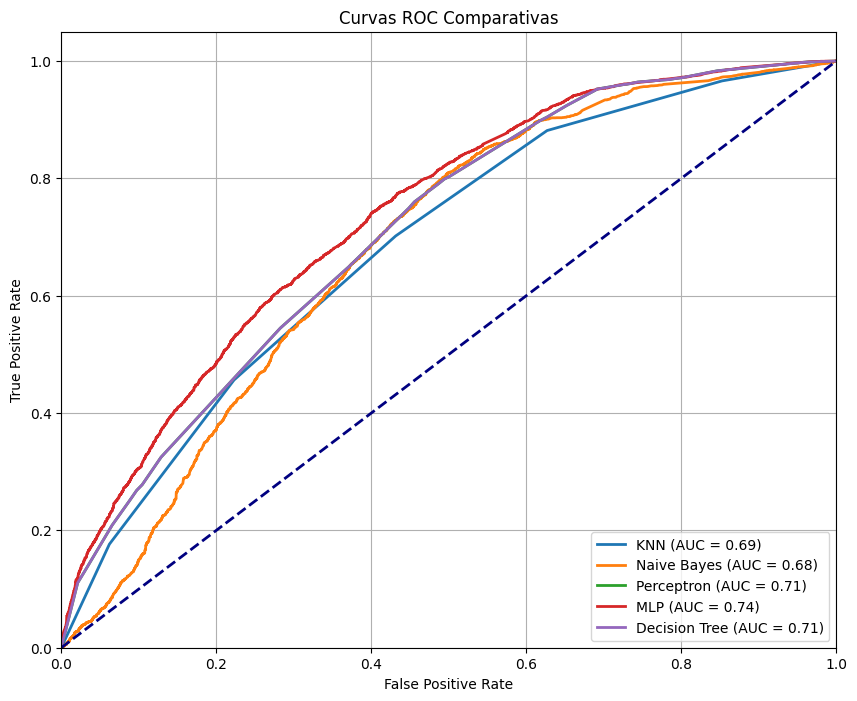

In [ ]:
def plot_roc_curve(y_test, y_score, label=None):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(10, 8))

models = {
    "KNN": clf_knn,
    "Naive Bayes": clf_bayes,
    "Perceptron": clf_tree,
    "MLP": clf_mlp,
    "Decision Tree": clf_tree
    #"SVM": best_clf
}

for name, model in models.items():
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)

    plot_roc_curve(y_test, y_score, label=name)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC Comparativas')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Non Supervised Models

In [ ]:
import scipy.cluster.hierarchy as sch
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score, jaccard_score
from sklearn.metrics import confusion_matrix, recall_score, f1_score

In [ ]:
def plot_silhouette(X, labels):
    silhouette_avg = silhouette_score(X, labels)
    sample_silhouette_values = silhouette_samples(X, labels)

    print(f"Silhouette avg: {silhouette_avg:.4f}")

    n_clusters = len(np.unique(labels))

    fig, ax = plt.subplots(figsize=(10, 7))

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax.set_title("Gráfico de Silhueta para os Clusters")
    ax.set_xlabel("Valor do Coeficiente de Silhueta")
    ax.set_ylabel("Cluster")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])
    ax.set_xticks(np.arange(-0.1, 1.1, 0.2))

    plt.show()

### K-Means

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=123456)
clustering = kmeans.fit_predict(df_p_clean)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
clustering

array([1, 1, 1, ..., 0, 0, 1], dtype=int32)

In [ ]:
silhouette_avg = silhouette_score(df_p_clean, clustering)
print("Silhouette avg:", silhouette_avg)

Silhouette avg: 0.5296736359464975


In [ ]:
for i in range(2):
    lab = y[clustering == i]
    print(f"Cluster {i} - Doentes:", np.sum(lab), "Não Doentes:", len(lab) - np.sum(lab))

Cluster 0 - Doentes: 15398 Não Doentes: 8978
Cluster 1 - Doentes: 37437 Não Doentes: 33306


Silhouette avg: 0.5297


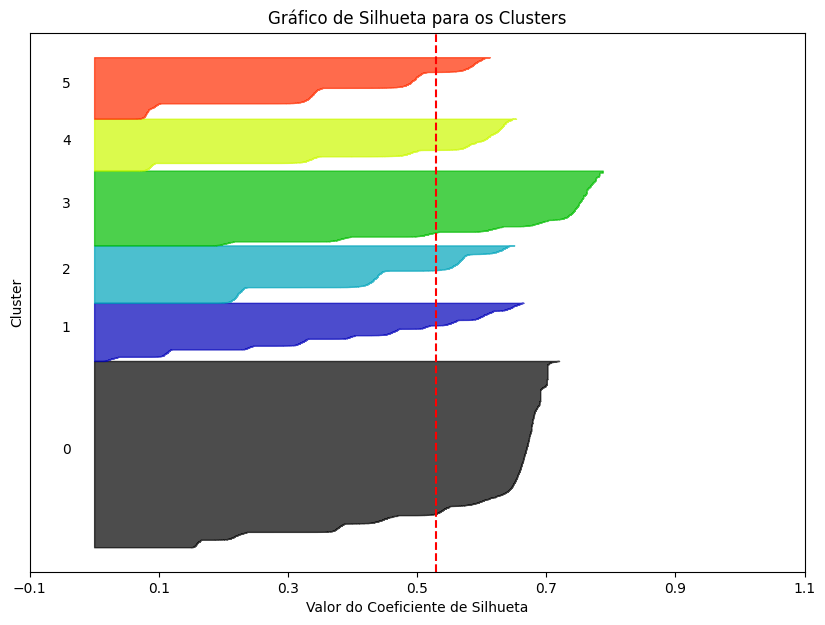

In [ ]:
plot_silhouette(df_p_clean, clustering)

In [ ]:
jaccard_score(y, clustering, average='macro')

0.2951239424104527

In [ ]:
conf_matrix = confusion_matrix(y, clustering)
print("Matriz de Confusão:\n", conf_matrix)

In [ ]:
accuracy = recall_score(y, clustering)
print("Recall:", accuracy)
f1 = f1_score(y, clustering, average='weighted')
print("F1 Score:", f1)

Recall: 0.7085643985994132
F1 Score: 0.45628971453765943


### Complete-Link

In [ ]:
df_p_clean_sampled, _ , y_sampled , y_ = train_test_split(df_p_clean,y, test_size=0.8, random_state=42)

clustering = AgglomerativeClustering(n_clusters=2, linkage='complete')
labels = clustering.fit_predict(df_p_clean_sampled)
labels

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
silhouette_avg = silhouette_score(df_p_clean_sampled, labels)
print("Silhouette avg:", silhouette_avg)

Silhouette avg: 0.48111038632360703


In [ ]:
cluster_0_labels = y_sampled[labels == 0]
cluster_1_labels = y_sampled[labels == 1]

print("Cluster 0 - Doentes:", np.sum(cluster_0_labels), "Não Doentes:", len(cluster_0_labels) - np.sum(cluster_0_labels))
print("Cluster 1 - Doentes:", np.sum(cluster_1_labels), "Não Doentes:", len(cluster_1_labels) - np.sum(cluster_1_labels))

Cluster 0 - Doentes: 6533 Não Doentes: 5221
Cluster 1 - Doentes: 4025 Não Doentes: 3244


Silhouette avg: 0.4811


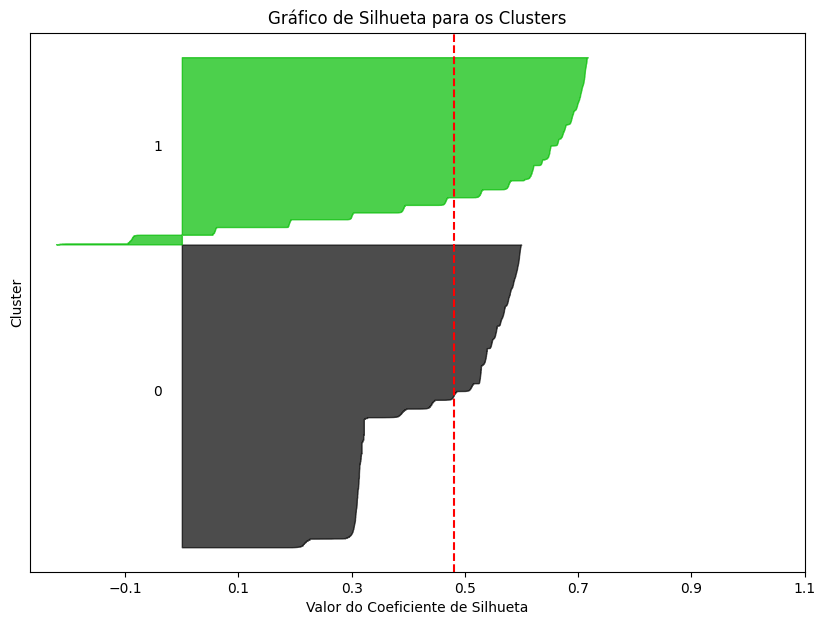

In [ ]:
plot_silhouette(df_p_clean_sampled, labels)

In [ ]:
jaccard_score(y_sampled ,labels, average='macro')

0.31986874200238724

In [ ]:
conf_matrix = confusion_matrix(y_sampled, labels)
print("Matriz de Confusão:\n", conf_matrix)

Matriz de Confusão:
 [[5221 3244]
 [6533 4025]]


In [ ]:
accuracy = recall_score(y_sampled, labels)
print("Recall:", accuracy)
f1 = f1_score(y_sampled, labels, average='weighted')
print("F1 Score:", f1)

Recall: 0.38122750520932
F1 Score: 0.480434233016894


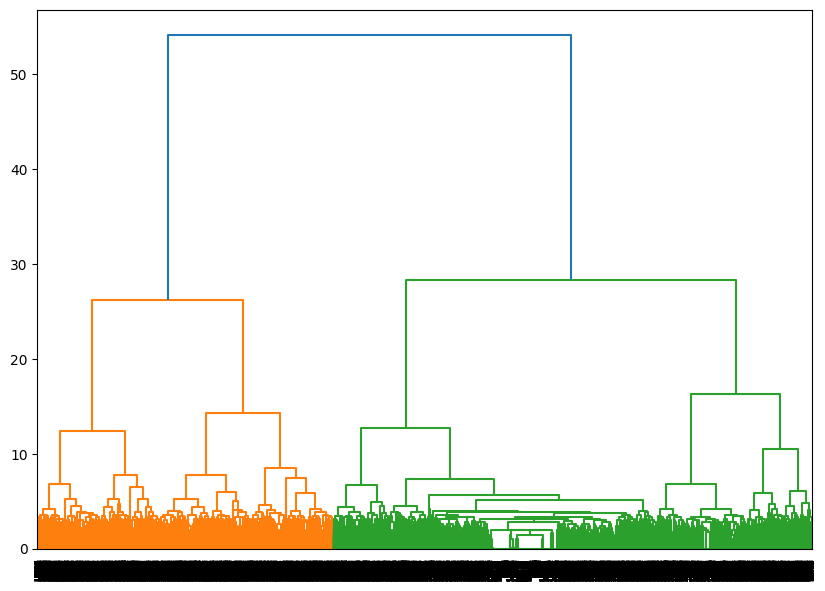

In [ ]:
# Montar Dendograma
distance_matrix = sch.distance.pdist(df_p_clean_sampled)
linkage_matrix = sch.linkage(distance_matrix, method='complete')
plt.figure(figsize=(10, 7))
sch.dendrogram(linkage_matrix)
plt.show()